# Inpainting and Repainting

*Robert McAnany*

*April 10, 2016*

This paper explores inpainting and repainting.  It was a programming exercise from Duke Professor Guillermo Sapiro's 2016 Coursera class _"Image and Video Processing from Mars to Hollywood with a Stop at the Hospital"_.  

Inpainting is the technique of automatically filling in missing information in an image.  Several methods have been developed.  One, pioneered by Bertalmio, Sapiro, et al, employs partial differential equations to guide the process. [1]  A derivative (no pun intended) of this idea, the exemplar-based inpainting approach of Criminisi et al, will be followed in this assignment. [2]  It is briefly described below.

Repainting, also called texture transfer or image quilting, is the technique of re-rendering one image in the style of another.  Repainting has a long history with many sophisticated approaches, e.g., [3] and [4].  In this assignment we do simple patch matching, employing the machinery already developed for exemplar impainting.


In [1]:
from __future__ import division, print_function
import numpy as np
import inpaint_functions as IF
from IPython.display import Image as ipImage
%matplotlib inline

## Inpainting

As a running example for this assignment, the iconic painting "American Gothic" by Grant Wood [5] will be used.

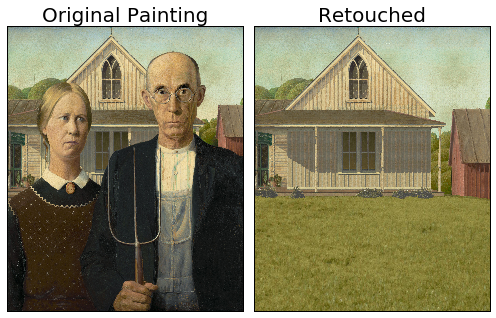

In [2]:
I_original = IF.read_image("./ag_original.jpg", float=False)
I_retouch = IF.read_image("./ag_retouch.jpg", float=False)
IF.plot_rxc([I_original, I_retouch], ["Original Painting", "Retouched"])

Impressed?  Well, don't be.  The retouched image was done with Photoshop, not with inpainting.  However there are several artifacts that need to be repaired.  Inpainting will be used for those.

Here's how inpainting fared with no help from Photoshop.

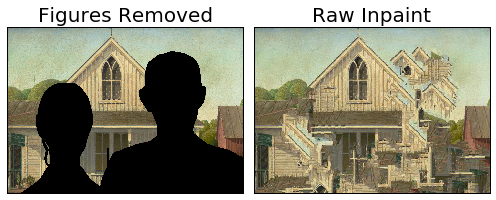

In [3]:
I_original = IF.read_image("./ag_masked.jpg", float=False)[:3500,:,:]
I_raw_repaint = IF.read_image("./ag_raw_repaint.jpg", float=False)
IF.plot_rxc([I_original, I_raw_repaint], ["Figures Removed", "Raw Inpaint"])
I_original=None; I_retouch=None; I_raw_repaint=None

Such a result might work in the right context, like an art gallery.  Of course, this example is extremely challenging.  As will be demonstrated, exemplar inpainting is quite capable in the right circumstances.  The algorithm is briefly explained next.

### Exemplar-Based Inpainting Algorithm

The basic idea is to copy patches from the known region to the unknown region based on some priority measure.

<img src="exemplar_inpainting_sketch.png", width=500>

> **Structure propagation by exemplar-based texture synthesis.** (a) Original image, with the target region $\Omega$, its contour $\partial\Omega$, and the source region $\Phi$ clearly marked. (b) We want to synthesize the area delimited by the patch $\Psi_{p}$ centred on the point $p\in\partial\Omega$. (c) The most likely candidate matches for $\Psi_{p}$ lie along the boundary between the two textures in the source region, e.g., $\Psi_{q'}$ and $\Psi_{q''}$. (d) The best matching patch in the candidates set has been copied into the position occupied by $\Psi_{p}$, thus achieving partial filling of $\Omega$. Notice that both texture and structure (the separating line) have been propagated inside the target region. The target region $\Omega$ has, now, shrank and its front $\partial\Omega$ has assumed a different shape. _(Diagram and caption reprinted from [2])_

#### Priority, Confidence and Data Terms

Pixels are selected for inpainting based on maximum _priority_.  Priority, $P(p)$, is calculated as the product of two quantities: the _confidence_ term and the _data_ term.  

Confidence, $C(p)$, represents the degree of certainty with which a given pixel's value is known.  It is initialized in the known region, $\Phi$, to 1 and in the unknown region, $\Omega$, to 0.  As pixels are inpainted, their confidence is updated as the average of the confidence values around them.  The precise equation is given below.

The data term, $D(p)$, measures the strength of edges incident on the unknown region.  Strong edges are given higher priority.  The following diagram illustrates the calculation.

<img src="exemplar_vectors_sketch.png" width=150>

> **Notation diagram.** Given the patch $\Psi_{p}$, $\mathbf{n}_p$ is the normal to the contour
$\partial\Omega$ of the target region $\Omega$ and $\nabla \mathcal{I}_p^{\perp}$ is the isophote (direction and intensity) at point $p$. The entire image is denoted with $\mathcal{I}$.  _(Diagram and caption reprinted from [2])_

Formally,

$$
C(p) = \frac{\sum_{q \in \Psi_p \cap (\mathcal{I} - \Omega)}C(q)}{|\Psi_p|}
, \qquad D(p) = \frac{\nabla I_p^\perp \centerdot \mathbf{n}_p}{\alpha}
, \qquad P(p) = C(p) D(p)
$$

And the pixel with highest priority is

$$
\hat p = \text{arg max}_{p \in \partial\Omega^t} P(p)
$$


#### Closest Matching Exemplar

Once the pixel with the highest priority is identified, the infill patch must be selected.  It is simply the one from the known region that is most similar.  Here, the similarity measure is the sum of squared difference between the two patches.

Formally,

$$
\begin{align}
\Psi_{\hat q} \in \Phi &= \text{arg min} \ d(\Psi_{\hat p}, \Psi_{\hat q}) \\
d(\Psi_{\hat p}, \Psi_{\hat q}) &= \sum_{i,j,k}(\Psi_{\hat p} - \Psi_{\hat q})^2
\end{align}
$$

#### Algorithm Pseudocode

1. Extract the manually selected initial fill front $\partial\Omega^0$.
1. Repeat:
  1. Identify the fill front $\partial\Omega$.  If $\Omega^t = 0$, exit.
  1. Compute priorities $P(p) \ \forall p \in \partial\Omega^t$.
  1. Find the patch $\Psi_{\hat p}$ with the maximum priority, _i.e.,_ $\hat p = \text{arg max}_{p \in \partial\Omega^t} P(p)$.
  1. Find the exemplar $\Psi_{\hat q} \in \Phi$ that minimizes $d(\Psi_{\hat p}, \Psi_{\hat q})$.
  1. Copy image data from $\Psi_{\hat q}$ to $\Psi_{\hat p} \ \forall p \in \Psi_{\hat p} \cap \Omega$.
  1. Update $C(p) \ \forall p \in \Psi_{\hat p} \cap \Omega$.


### Inpainting Step by Step

To see the process in action, all the steps to inpaint one patch will be shown.  

This section follows the exposition by a classmate in the course, Robert Metchev.  Here is the link to his code: https://github.com/rmetchev/IVP-Python/blob/master/Week7.ipynb

#### Source and Target Regions

Referring to the retouched image, there are some faint dark lines just above the porch roof on the right side.  These are copy/paste artifacts and will be the target region for inpainting.  The area to the left of the upper window is reasonably free of defects; it will serve as the source region for inpaint patches.  In this step-by-step section, one small artifact will be repainted.

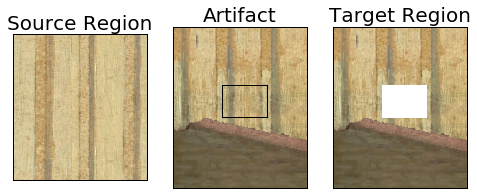

In [4]:
I = IF.read_image("./ag_retouch.jpg", float=True)

I_s = np.copy(I[1350:1650, 1525:1800, :]) # Source region.

y0 = 110; x0 = 90; y1 = 170; x1 = 175 # Target region.

I_c = np.copy(I[1600:1900, 2700:2950, :]) # Corrupted image.
I_c[y0:y1, x0:x1, :] = 1

I_tmp = np.copy(I[1600:1900, 2700:2950, :])
I_tmp = IF.add_rectangle(I_tmp, y0, x0, y1, x1, color="k", width=2)

ims = [I_s, I_tmp, I_c]
titles = ["Source Region", "Artifact", "Target Region"]
IF.plot_rxc(ims, titles)

I = None

#### Mask $\Omega$, Confidence $C(p)$, and Boundary $\partial\Omega$

The first step is to initialize the parameters.  Please note, to minimize clutter in this notebook, most of the working code was moved to the companion file `inpainting_functions.py`.  Please refer to that file for details.

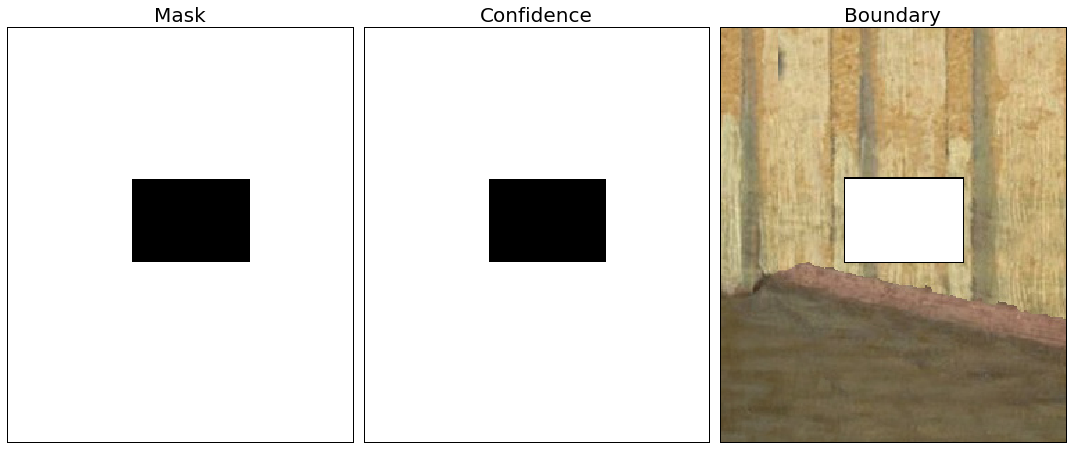

In [5]:
M = np.ones_like(I_c[:, :, 0]) # Mask (Omega)
M[y0:y1, x0:x1] = 0

C = IF.initialize_confidence(M) # Confidence (C(p))

B = IF.get_boundary(M) # Boundary (d Omega)

I_tmp = np.copy(I_c)
I_tmp[B==1, :] = 0

ims = [M, C, I_tmp]
titles = ["Mask", "Confidence", "Boundary"]

IF.plot_rxc(ims, titles, fs=15)

#### Gradients $\nabla I$, Isophotes $\nabla I^{\perp}$, and Normals $\mathbf{n}$

To calculate the data term, the image isophotes and mask normals are required.  The isophotes are perpendicular to the image gradient.  

Only the vectors along the mask boundary are required.  This requires some bookkeeping, described next.

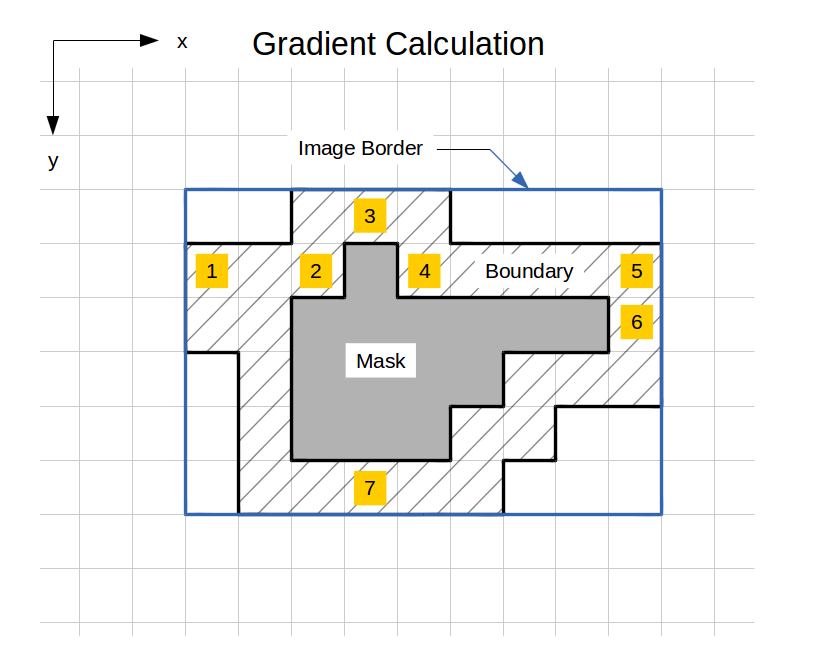

In [6]:
ipImage(filename='./gradient_sketch.png', width=400) 

To calculate the gradient at a given pixel location, adjacent pixel values are used.  In this case, the pixels in the mask region are unknown, as are those outside the image border.  

Inspecting the sketch we can see which pixels are valid for the calculation.  Denoting a valid direction with the binary variable, $V_{dir}$, with $dir \in L,R,U,D$ (i.e., left, right, up, down), we get

$$
\nabla_y = 
\left\{ \begin{array}{rcl}
\frac{1}{2}(p_{y+1} - p_{y-1}) & \mbox{if} & V_U \cap V_D & \mathit{e.g. pt \ 6}\\ 
p_{y+1} - p_{y} & \mbox{if} & \overline{V_U} \cap V_D  & \mathit{e.g. pts \ 1 \& 5}\\ 
p_{y} - p_{y-1} & \mbox{if} & V_U \cap \overline{V_D}  & \mathit{e.g. pts \ 2 \& 4}\\ 
0 & \mbox{if} & \overline{V_U} \cap \overline{V_D}  & \mathit{e.g. pts \ 3 \& 7}\\ 
\end{array}\right.
$$

$$
\nabla_x = 
\left\{ \begin{array}{rcl}
\frac{1}{2}(p_{x+1} - p_{x-1}) & \mbox{if} & V_L \cap V_R & \mathit{e.g. pts \ 3 \& 7} \\ 
p_{x+1} - p_{x} & \mbox{if} & \overline{V_L} \cap V_R & \mathit{e.g. pts \ 1 \& 4} \\ 
p_{x} - p_{x-1} & \mbox{if} & V_L \cap \overline{V_R} & \mathit{e.g. pts \ 2 \& 5} \\ 
0 & \mbox{if} & \overline{V_L} \cap \overline{V_R} & \mathit{e.g. pt \ 6} \\ 
\end{array}\right.
$$

Now the vector quantities can be calculated.

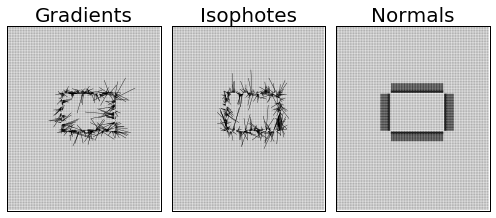

In [7]:
grad = IF.get_grad(I_c, M, B)
isophote = IF.get_isophote(grad)
normal = IF.get_mask_normal(M, B)

vecs = [grad, isophote, normal]
titles = ["Gradients", "Isophotes", "Normals"]
scales = [0.5, 0.5, 15]
IF.plot_quivers(vecs, titles, scales)

#### Data Term $D(p)$, Priority $P(p)$, and Patch to Inpaint $\Psi_{\hat p}$

Now the data term (an inner product of two vectors) can be calculated.  The priority is obtained by multiplying the data term with the confidence.  The pixel with the maximum priority is the one to inpaint.

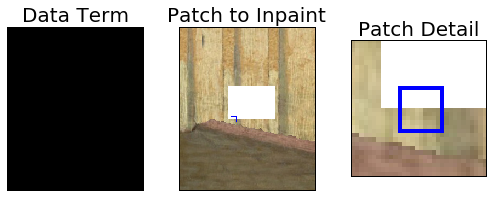

In [8]:
inner = IF.get_inner(I_c, M, B)

patch_size = 11

y0t, x0t, y1t, x1t = IF.get_patch_to_inpaint_indices(C, inner, patch_size)

I_tmp = IF.add_rectangle(I_c, y0t, x0t, y1t, x1t, color="b")
d = patch_size
I_tmp2 = I_tmp[y0t-d:y1t+d, x0t-d:x1t+d, :]

ims = [inner, I_tmp, I_tmp2]
titles = ["Data Term", "Patch to Inpaint", "Patch Detail"]
IF.plot_rxc(ims, titles)

Note that the patch is centered at the pixel location.  If the pixel is at the border of the image, the patch will extend beyond it.  This is an issue for extracting patches as well as inserting them.  Some more bookkeeping is required.

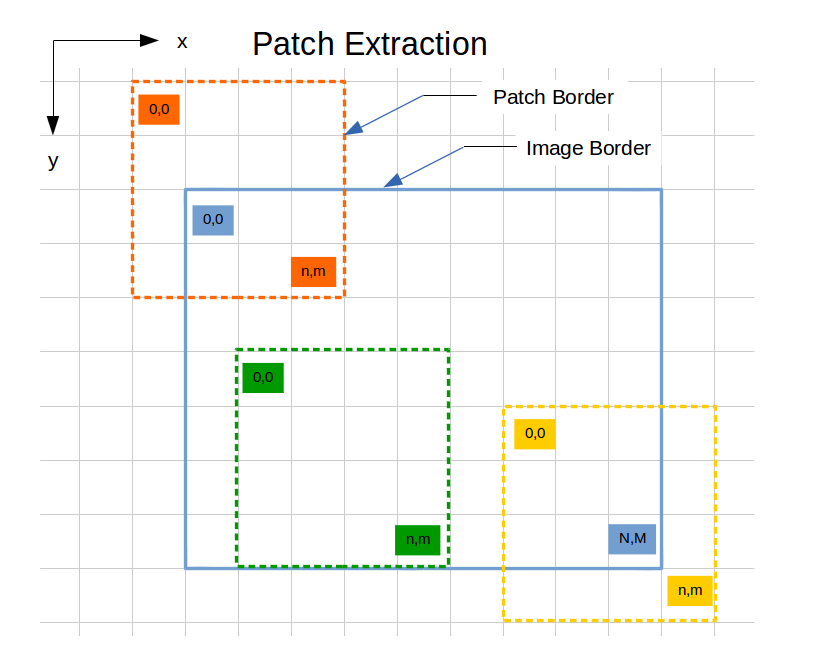

In [9]:
ipImage(filename='./patch_extraction_sketch.png', width=400) 

The patch to be extracted is defined in image coordinates.  These need to be reconciled with the coordinates of the patch itself.  Also, pixels that fall outside the boundary of the image need to be filled with some default value.

The desired extraction code will be of the following form in python.  Note that with slicing syntax, the trailing index number is incremented by 1.

`patch[y0_patch:y1_patch + 1, x0_patch:x1_patch + 1] = im[y0_im:y1:im + 1, x0_im:x1_im + 1]`

Inspecting the patches in the sketch we can observe

```
if y0 >= 0:
    y0_patch = 0
    y0_im = y0
if y0 < 0:
    y0_patch = -y0
    y0_im = 0
if y1 <= N:
    y1_patch = patch_size - 1
    y1_im = y1
if y1 > N:
    y1_patch = (patch_size - 1) - (y1 - N)
    y1_im = N
```
The same reasoning applies in the horizontal direction.

The corners of the image provide a good test case.  The first section below extracts patches extending past the corners of the image.  The second section inserts patches at those locations.  A tiny portion of the image is used so the patches can be more easily seen.

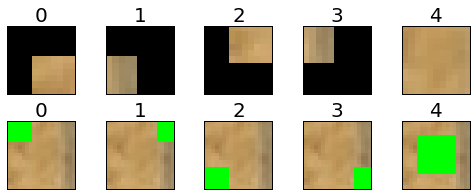

In [10]:
I_tmp = np.copy(I_c[:19, :19, :])
NN = I_tmp.shape[0] - 1; MM = I_tmp.shape[1] - 1
dy = int(patch_size/2.0); dx = int(patch_size/2.0) - 1
y0_vals = np.array([-dy, -dy, NN-dy, NN-dy, int(NN/2)-dy])
y1_vals = y0_vals + patch_size - 1
x0_vals = np.array([-dx, MM-dx, -dx, MM-dx, int(MM/2)-dx-1])
x1_vals = x0_vals + patch_size - 1

ims = []
titles = []

for i in range(len(y0_vals)):
    ims.append(IF.get_patch_contents(I_tmp, y0_vals[i], x0_vals[i], 
                                     y1_vals[i], x1_vals[i], 
                                     patch_size))
    s = str(y0_vals[i]) + ", " + str(x0_vals[i]) + ", "
    s = s + str(y1_vals[i]) + ", " + str(x1_vals[i])
    titles.append(str(i))

patch_content = np.zeros((patch_size, patch_size, I_c.shape[2]))
patch_content[:, :, 1:2] = 1

for i in range(len(y0_vals)):
    ims.append(IF.put_patch_contents(I_tmp, patch_content, 
                                     y0_vals[i], x0_vals[i], 
                                     y1_vals[i], x1_vals[i], 
                                     patch_size))
    s = str(y0_vals[i]) + ", " + str(x0_vals[i]) + ", "
    s = s + str(y1_vals[i]) + ", " + str(x1_vals[i])
    titles.append(str(i))

IF.plot_rxc(ims, titles, ncol=5)
I_tmp = None; I_tmp2 = None

Above, patches were smaller than the image.  They can potentially be larger.  The following code checks that condition.

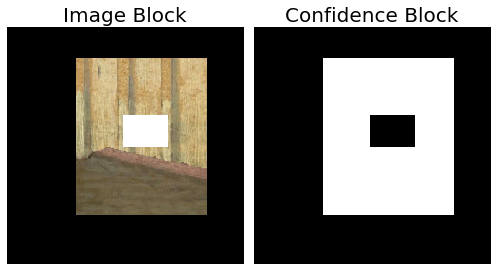

In [11]:
block_size = int(1.5*I_c.shape[0])
if block_size % 2 == 0: block_size += 1 # Odd size only.

I_block = IF.get_patch_contents_centered(I_c, y0t, x0t, y1t, 
                                         x1t, block_size, 
                                         default_fill=0) 
C_block = IF.get_patch_contents_centered(C, y0t, x0t, y1t, x1t, 
                                         block_size, 
                                         default_fill=0)
ims = [I_block, C_block]
titles = ["Image Block", "Confidence Block"]
IF.plot_rxc(ims, titles)

#### Infill Patch $\Psi_{\hat q}$

The candidate infill patches are drawn from the source region as defined above.  All overlapping patches can be considered.  However, the number of overlapping patches in even a modestly sized image can be quite large.  For that reason the maximum number of patches is limited.

To reduce the number of patches, adjacent patch differences are calculated in both directions.  Only patches with the largest differences are retained.  In this example, 5000 patches are kept.  Some randomly selected patches are shown.

Patch Matrix size: (5000, 11, 11, 3)


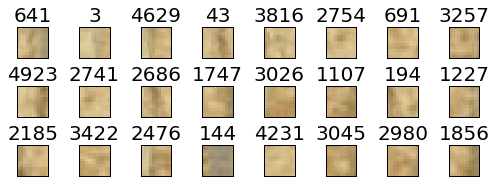

In [12]:
I_sm = np.ones_like(I_s[:,:,0])
PM = IF.get_patch_matrix(I_s, I_sm, patch_size, max_patches=5000)
print("Patch Matrix size:", PM.shape)

ims = []
titles = []
for i in range(24):
    idx = np.random.randint(0, PM.shape[0])
    ims.append(PM[idx])
    titles.append(str(idx))
    
IF.plot_rxc(ims, titles, ncol=8)

Now the best infill patch can be found.  

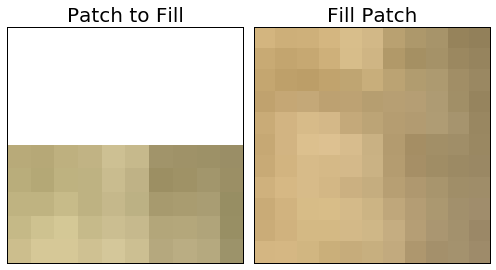

In [13]:
fill_patch = IF.get_best_fill_patch(I_c, M, C, y0t, x0t, y1t, x1t, 
                                    patch_size, patch_matrix=PM)

ims = [I_c[y0t:y1t, x0t:x1t], fill_patch]
titles = ["Patch to Fill", "Fill Patch"]

IF.plot_rxc(ims, titles, ncol=2)

#### Update Image and Parameters

The infill patch can now be applied.  To proceed to the next patch, the mask $\Omega$, boundary, $\partial\Omega$, confidence, $C(p)$, and data term $D(p)$ all need to be updated.  The image is updated first, then the parameters.

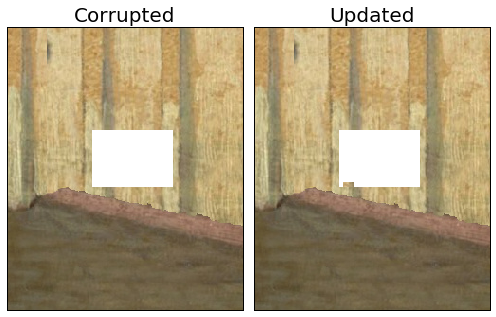

In [14]:
I_r = IF.update_image(I_c, M, fill_patch, y0t, x0t, y1t, x1t, patch_size)

ims = [I_c, I_r]
titles = ["Corrupted", "Updated"]
IF.plot_rxc(ims, titles)

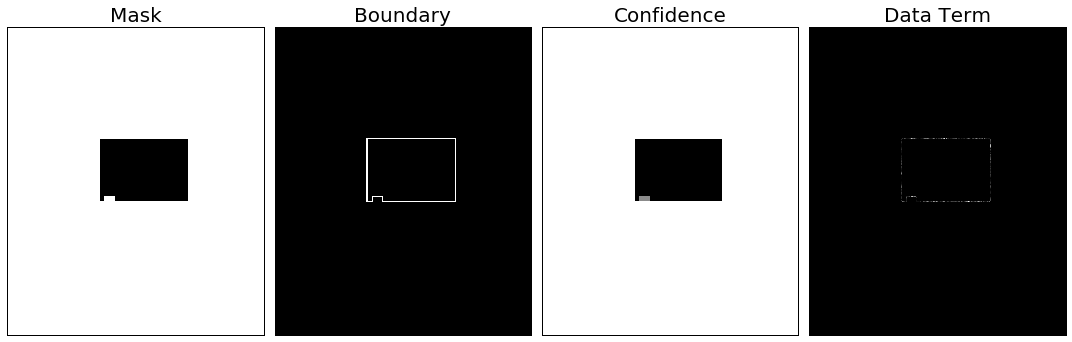

In [15]:
C, M, B, inner = IF.update_parameters(C, M, B, y0t, x0t, y1t, x1t, I_r, patch_size, inner)

ims = [M, B, C, inner]
titles = ["Mask", "Boundary", "Confidence", "Data Term"]
IF.plot_rxc(ims, titles, ncol=4, fs=15)

#### Inpaint the region

The example above showed how one patch is filled.  Now the entire region can be processed.

2016-04-11 09:27:42 0.0 % complete.  c= 5045
2016-04-11 09:27:46 20.0 % complete.  c= 4042
2016-04-11 09:27:51 40.0 % complete.  c= 3055
2016-04-11 09:27:56 60.0 % complete.  c= 2034
2016-04-11 09:28:01 80.0 % complete.  c= 1007


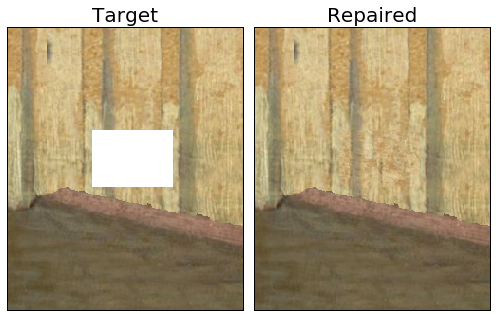

In [16]:
patch_size = 11
max_patches = 25000

I = IF.read_image("./ag_retouch.jpg", float=True)

I_s = np.copy(I[1350:1650, 1525:1800, :])
I_sm = np.ones_like(I_s[:, :, 0])

I_c = np.copy(I[1600:1900, 2700:2950, :])
I = None

y0 = 110; x0 = 90; y1 = 170; x1 = 175
M = np.ones_like(I_c[:, :, 0])
M[y0:y1, x0:x1] = 0
I_c[M==0, :] = 1

I_c, I_r = IF.infill(I_c, M, patch_size, patch_source = I_s, 
                    patch_mask = I_sm, max_patches = max_patches)

IF.plot_rxc([I_c, I_r], ["Target", "Repaired"])

#### Repair Artifacts in the Retouched Image

Returning to the original task, all artifacts will now be inpainted.

In [17]:
mask_coords_upper = []
mask_coords_upper.append([1640, 1700, 2760, 3400])
mask_coords_upper.append([1710, 1775, 2870, 3490])
mask_coords_upper.append([1800, 1860, 3220, 3585])

source_coords_upper = [1350, 1650, 1525, 1800]

mask_coords_lower = []
mask_coords_lower.append([2330, 2440, 2765, 3610])
mask_coords_lower.append([2590, 2720, 2790, 3525])
mask_coords_lower.append([2720, 2850, 2790, 3525])

mask_coords_lower.append([2330, 2450, 800, 1245])
mask_coords_lower.append([2590, 2720, 800, 1245])
mask_coords_lower.append([2720, 2850, 975, 1245])

mask_coords_lower.append([2330, 2450, 1375, 1710])
mask_coords_lower.append([2720, 2850, 1375, 1710])
mask_coords_lower.append([2590, 2720, 1375, 1710])

source_coords_lower = [2500, 2650, 2760, 2920]
    
I_tmp = IF.read_image("./ag_retouch.jpg", float=False)
I_tmp = I_tmp[:4000, :, :]
I_tmp2 = np.copy(I_tmp)
w = 12

y0=source_coords_upper[0]; x0=source_coords_upper[2]
y1=source_coords_upper[1]; x1=source_coords_upper[3]
I_tmp2 = IF.add_rectangle(I_tmp2, y0, x0, y1, x1, color="w", width=w)

for mc in mask_coords_upper:
    y0=mc[0]; x0=mc[2]; y1=mc[1]; x1=mc[3]
    I_tmp2 = IF.add_rectangle(I_tmp2, y0, x0, y1, x1, color="r", width=w)

y0=source_coords_lower[0]; x0=source_coords_lower[2]
y1=source_coords_lower[1]; x1=source_coords_lower[3]
I_tmp2 = IF.add_rectangle(I_tmp2, y0, x0, y1, x1, color="w", width=w)

for mc in mask_coords_lower:
    y0=mc[0]; x0=mc[2]; y1=mc[1]; x1=mc[3]
    I_tmp2 = IF.add_rectangle(I_tmp2, y0, x0, y1, x1, color="r", width=w)

ims = [I_tmp2]
titles = ["Artifacts (Red), Source (White)"]
# IF.plot_rxc(ims, titles)
    

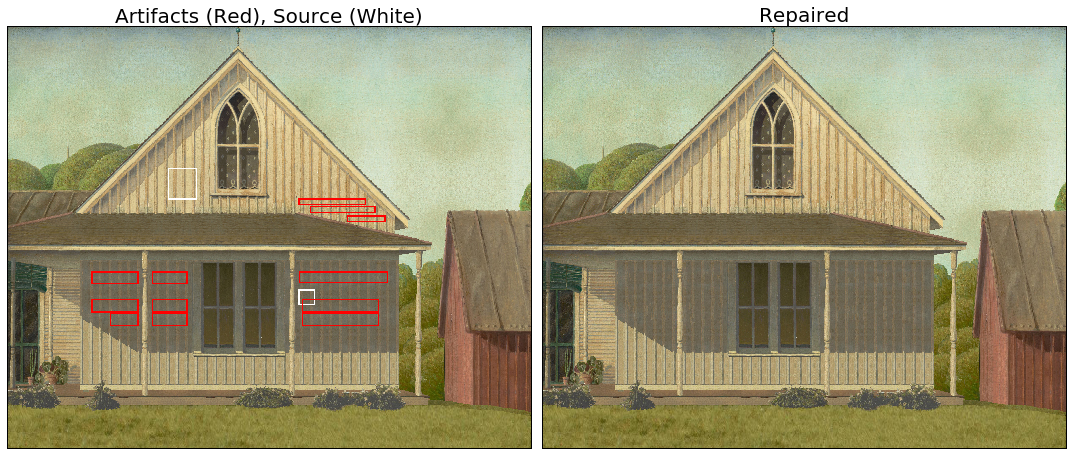

In [18]:
start_file = "./ag_retouch.jpg"

run_this = False # ~1 hr run time

if run_this: 

    max_patches = 25000
    save_file = "./ag_inpaint_"

    ## Starting Point
    img_file = start_file
    
    ## Upper Gable
    patch_size = 13 # Odd number only.

    for mc in mask_coords_upper:
        print(mc)
        img_file = IF.infill_file(img_file, save_file, mc, patch_size, 
                           source_coords_upper, max_patches=max_patches)
        print(img_file)
    

    ## Porch Back Wall
    patch_size = 11 # Odd number only.

    for mc in mask_coords_lower:
        print(mc)
        img_file = IF.infill_file(img_file, save_file, mc, patch_size, 
                           source_coords_lower, max_patches=max_patches)
        print(img_file)


I_start = IF.read_image(start_file, float=False)
end_file = "./ag_inpaint.jpg"
I_end = IF.read_image(end_file, float=False)[:4000, :, :]
IF.plot_rxc([I_tmp2, I_end], ["Artifacts (Red), Source (White)", "Repaired"], fs=15)

## Repainting

The original painting does not have any grass in the foreground.  It is easy to find images of grass on the internet, but they don't necessarily match the style of the painting.  One solution is to take a suitable sample and repaint it.  

In this case, the sample was an image of a park in Amsterdam. [6]  The trees in the original painting were used as the source for repaint patches.



The original and repainted images are approximately 5000 x 1250 pixels.  Repainting all 6.25 million pixels takes about two hours, running three threads in parallel, on a four-core 3.4 GHz machine with 8 GB RAM.  Here a tiny section will be repainted.

2016-04-11 09:28:27 0.0 % complete.  c= 249380
2016-04-11 09:28:44 20.0 % complete.  c= 199585
2016-04-11 09:29:05 40.0 % complete.  c= 149681
2016-04-11 09:29:28 60.0 % complete.  c= 99788
2016-04-11 09:29:54 80.0 % complete.  c= 49892


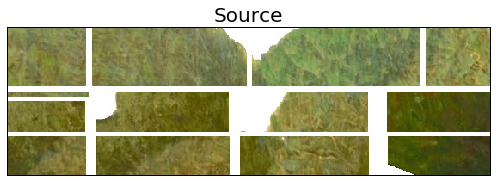

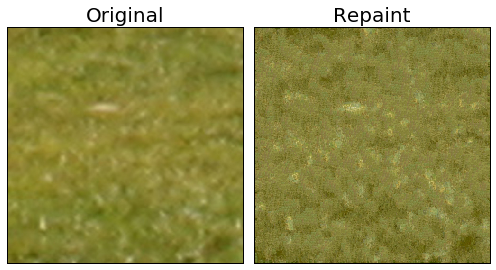

In [19]:
I_s = IF.read_image("ag_trees.jpg", float=True)

I_sm = np.ones((I_s.shape[0], I_s.shape[1]))
implied_mask = I_s == 1
implied_mask = np.logical_and(implied_mask[:, :, 0], 
                              implied_mask[:, :, 1], 
                              implied_mask[:, :, 2])
I_sm[implied_mask] = 0

I_o = IF.read_image("./grass.jpg", float=True)
I_o = I_o[500:1000, 2250:2750, :]

patch_size = 11
max_patches = 5000

I_r = IF.repaint(I_o, I_s, I_sm, patch_size, max_patches, verbose=1, update_every=0.2)

IF.plot_rxc([I_s], ["Source"])
IF.plot_rxc([I_o, I_r], ["Original", "Repaint"])


Here is another repaint example.  It is the house in Eldon, Iowa that served as a model for Wood's painting. [7][8]  The source for inpaint patches is the original painting itself.  

To get adequate results, the color balance of the original image was shifted as shown.  Otherwise the program had a difficult time getting good definition in the shadows.

Run time is approximately five hours on the machine described above.  For that reason, only the results are provided here.

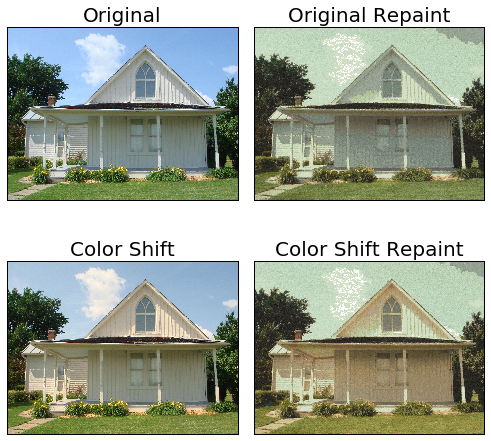

In [20]:
I_o = IF.read_image("./ag_real.jpg", float=True)

I_r = IF.read_image("./ag_real_repaint.jpg", float=False)

I_oc = np.copy(I_o)
I_oc[:, :, 2] = 0.9 * I_oc[:, :, 2]
I_oc[:, :, 0] = 1.1 * I_oc[:, :, 0]
I_oc = np.clip(I_oc, 0, 1)

I_rc = IF.read_image("ag_real_cc_repaint.jpg", float=False)

ims = [I_o, I_r, I_oc, I_rc]
titles = ["Original", "Original Repaint", "Color Shift", "Color Shift Repaint"]
IF.plot_rxc(ims, titles, ncol=2)

## Conclusion

Inpainting is an ill posed problem; a unique "correct" solution to fill in missing information in an image does not exist.  However, a correct solution is not necessary.  A visually plausible result is sufficient.  

In that light, Criminisi's exemplar-based inpainting technique is effective.  As we have seen, it can provide very believable results on real-world images.  And despite the intimidating mathematical notation, it is not too hard to implement.  

On the other hand, the challenge of removing the farmer and his wife from Wood's painting is beyond the ability of the algorithm.  A pixel-based approach is not enough.  To succeed at such a task, a program might benefit from "understanding" the objects in an image.  

Repainting is also an ill posed problem, but to a lesser degree.  Although there is no "right" answer, the underlying image helps guide the solution at each point along the way.  

The use of the exemplar machinery, with the proper manipulation of the input, worked well for repainting the examples shown.  However, such interventions are not ideal.  A better approach may be that of Gatys et al.  They use Deep Learning and obtain some striking results on the repainting task.  

In recent years, Deep Learning has made progress in object recognition.  A possible avenue for future research would be to apply that technology to inpainting.

<img src="./ag_robert.jpg", width=350>

## References

1. Marcelo Bertalmio, Guillermo Sapiro, Vincent Caselles, Coloma Ballester, Image Inpainting, Conference Proceedings of the 27th annual conference on Computer graphics and interactive techniques, Pages 417-424, 2000/7/1, ACM Press/Addison-Wesley Publishing Co.

1. A. Criminisi, P. Perez and K. Toyama, Region Filling and Object Removal by Exemplar-Based Image Inpainting, IEEE TRANSACTIONS ON IMAGE PROCESSING, VOL. 13, NO. 9, SEP 2004.

1. Alexei A. Efros and William T. Freeman. 2001. Image quilting for texture synthesis and transfer. In Proceedings of the 28th annual conference on Computer graphics and interactive techniques (SIGGRAPH '01). ACM, New York, NY, USA, 341-346. DOI=http://dx.doi.org/10.1145/383259.383296 

1. Leon A. Gatys, Alexander S. Ecker, Matthias Bethge.  2015.  A Neural Algorithm of Artistic Style.  http://arxiv.org/abs/1508.06576

1. Wood, Grant.  _American Gothic_. 1930.  Oil on Beaverboard.  Art Institute of Chicago.  https://en.wikipedia.org/wiki/American_Gothic#/media/File:Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg

1.  Sepp, S.  _Field of grass in the Oosterpark, Amsterdam._ 2007.  Photograph.   https://commons.wikimedia.org/wiki/File:Oosterpark_field_of_grass.JPG

1. _Essential Guide_. 2013. Art Institute of Chicago. http://www.artic.edu/aic/collections/artwork/6565

1. Strom, Jessica.  _American Gothic House_. 2007.  Photograph.  https://en.wikipedia.org/wiki/American_Gothic#/media/File:2007-06-04-Gothic_House.jpg